In [ ]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline  

In [ ]:
import os
from fastai import *
from fastai.vision import *

IMPORTING THE DATA

In [ ]:
#mounting the drive to the specified path 
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


In [ ]:
#specifying the path of the dataset 
path = Path('/content/drive/MyDrive/hwd')
dest = path   
#any missing parents of this path are created as needed if parents = True  
dest.mkdir(parents=True, exist_ok=True)   

In [ ]:
path.ls()

[PosixPath('/content/drive/MyDrive/hwd/spiral'),
 PosixPath('/content/drive/MyDrive/hwd/wave'),
 PosixPath('/content/drive/MyDrive/hwd/drawings'),
 PosixPath('/content/drive/MyDrive/hwd/models'),
 PosixPath('/content/drive/MyDrive/hwd/export.pkl')]

CREATING A DATABLOCK

In [ ]:
#the classes are defined  
classes = ['healthy', 'parkinson'] 

In [ ]:
len(classes)

2

In [ ]:
#applying transformations to all the images 
tfms = get_transforms(max_lighting=0.25)

In [ ]:
np.random.seed(42)
#fetching the images from the paths specified  
#spliting 20% of the images to the valid set 
#resizing and normalizing the image files
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.3,
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
#printing the number of classes
data.classes  

['healthy', 'parkinson']

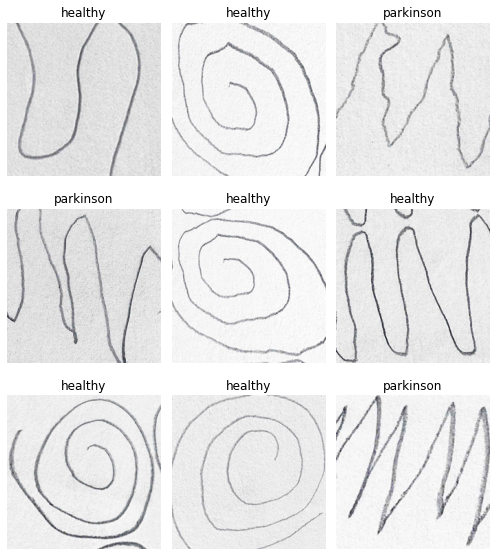

In [ ]:
#displaying the images in 3 rows
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
#displaying the classes
data.classes, data.c 

(['healthy', 'parkinson'], 2)

In [ ]:
#displaying the length of the training and validation datasets
len(data.train_ds), len(data.valid_ds) 

(286, 122)

In [ ]:
#number of images in each class in the training set
vc_train = pd.value_counts(data.train_ds.y.items, sort=False)
vc_train.index = data.classes; vc_train 

healthy      143
parkinson    143
dtype: int64

In [ ]:
#number of images in class in the valid set
vc_valid = pd.value_counts(data.valid_ds.y.items, sort=False)
vc_valid.index = data.classes; vc_valid

healthy      61
parkinson    61
dtype: int64

TRANSFER LEARNING

RESNET-50

In [ ]:
#using resnet 50 architecture  
arch = models.resnet50 

In [ ]:
#creating a convolutional neural network using resnet 50 architecture
learn = cnn_learner(data, arch, metrics=[accuracy, error_rate, 
                                         Precision(average='micro'),
                                         Recall(average='micro'),
                                         FBeta(average='micro'),
                                         AUROC()])    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
#training the classifier      
learn.fit_one_cycle(10)        

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

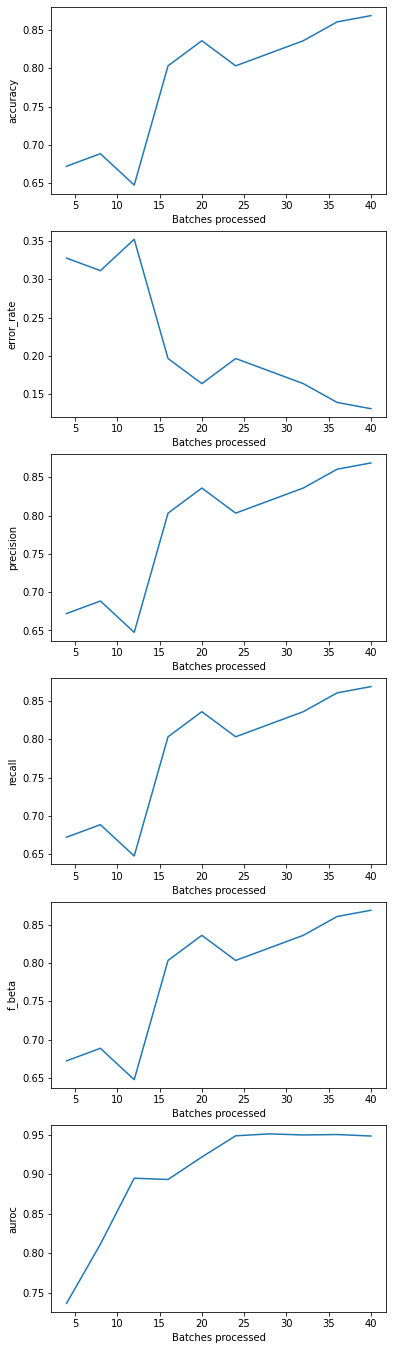

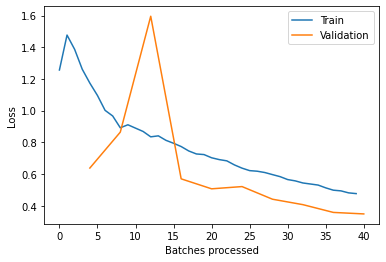

In [ ]:
#plotting the graph for metrics   
learn.recorder.plot_metrics() 
learn.recorder.plot_losses() 

In [ ]:
#saving the learner 
learn.save('RESNET-50-stage-1')

In [ ]:
#finding the learning rate that has minimum loss
learn.lr_find() 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.29E-03


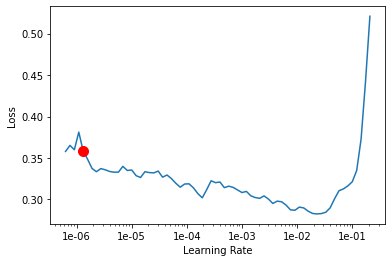

In [ ]:
#plotting the learning rate curve 
learn.recorder.plot(suggestion=True)

In [ ]:
#unfreezing the layers which don't contain BatchNorm 
learn.unfreeze() 

In [ ]:
#training the classifier with different learning rates
learn.fit_one_cycle(15,  max_lr=slice(1e-4,1e-2))        

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

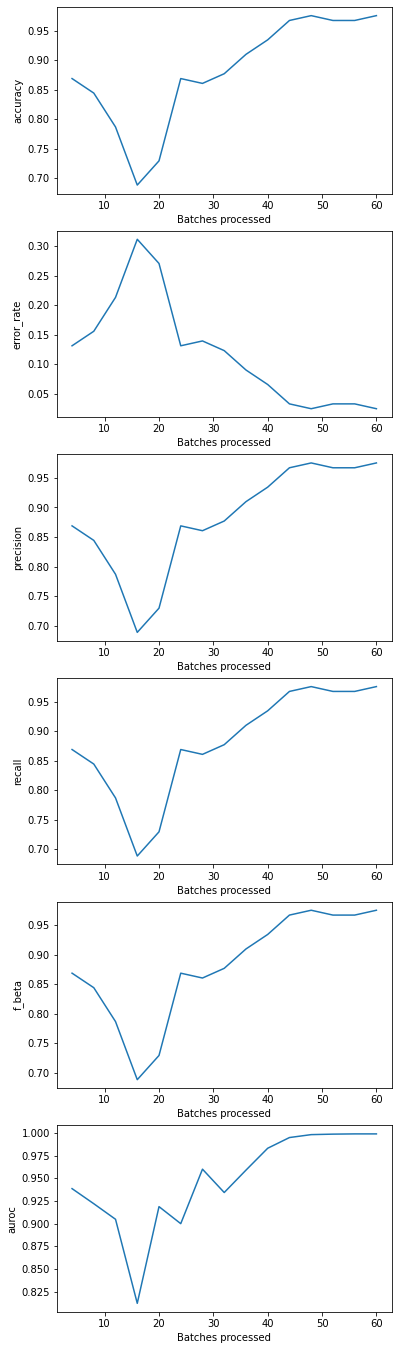

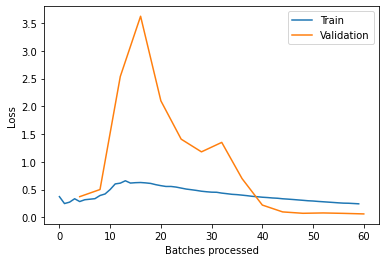

In [ ]:
#plotting the graph of metrics and losses 
learn.recorder.plot_metrics()
learn.recorder.plot_losses() 

In [ ]:
#saving the learner
learn.save('RESNET-50-stage-2')

In [ ]:
#classification interpretation contains the information about the model and the data 
interp = ClassificationInterpretation.from_learner(learn) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

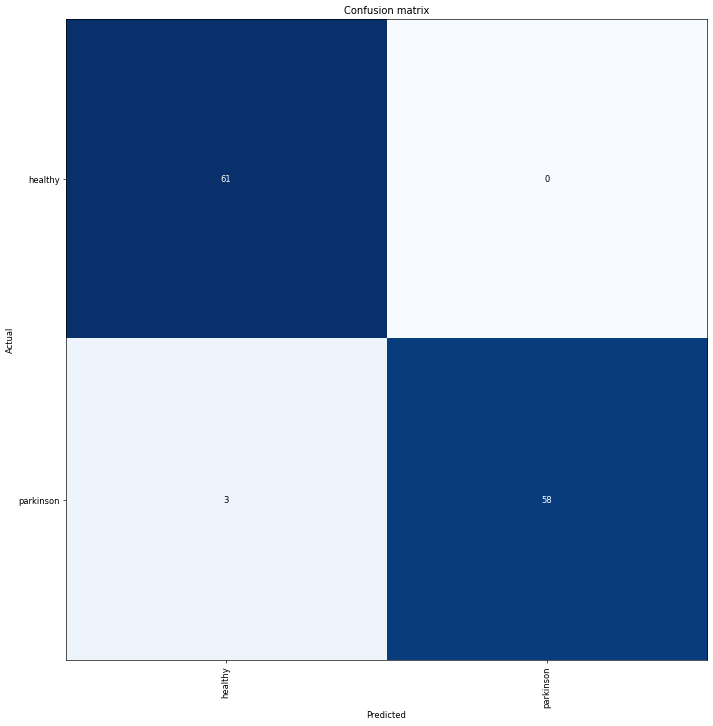

In [ ]:
#plotting the confusion matrix
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60) 

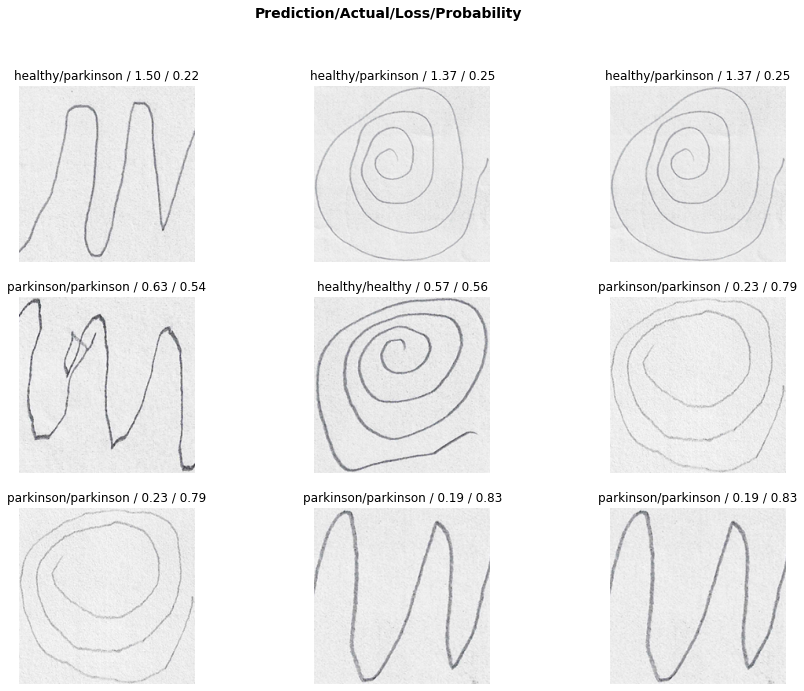

In [ ]:
#plotting the top losses
interp.plot_top_losses(9, figsize = (15,11))

In [ ]:
#most wrongly predicted images 
interp.most_confused(min_val = 2)  

[('parkinson', 'healthy', 3)]

In [ ]:
learn.summary()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

TRANSFER LEARNING

DENSENET-121

In [ ]:
#using densenet 121 architecture  
arch1 = models.densenet121 

In [ ]:
#creating a convolutional neural network using densenet 121 architecture
learn1 = cnn_learner(data, arch1, metrics=[accuracy, error_rate, 
                                         Precision(average='micro'),
                                         Recall(average='micro'),
                                         FBeta(average='micro'),
                                         AUROC()])    

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
#training the model 
learn1.fit_one_cycle(10) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

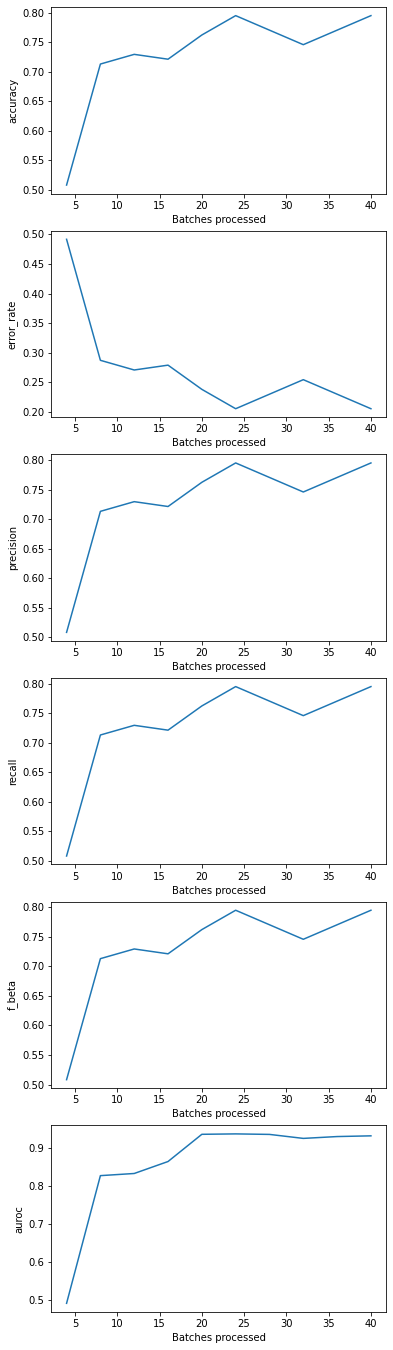

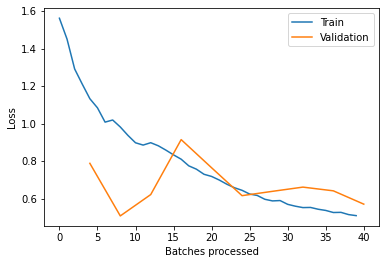

In [ ]:
#plotting the graph for metrics   
learn1.recorder.plot_metrics() 
learn1.recorder.plot_losses() 

In [ ]:
#saving the learner 
learn1.save('DENSENET-121-STAGE-1')

In [ ]:
#finding the learning rate that has minimum loss
learn1.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.58E-03


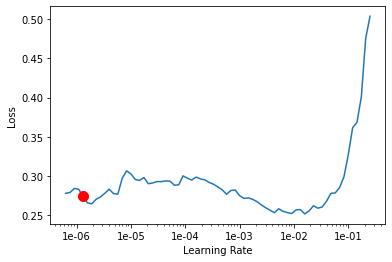

In [ ]:
#plotting the learning rate curve
learn1.recorder.plot(suggestion=True)

In [ ]:
#unfreezing the layers which don't contain BatchNorm 
learn1.unfreeze() 

In [ ]:
#training the classifier with different learning rates
learn1.fit_one_cycle(10,  max_lr=slice(1e-3,1e-2))  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

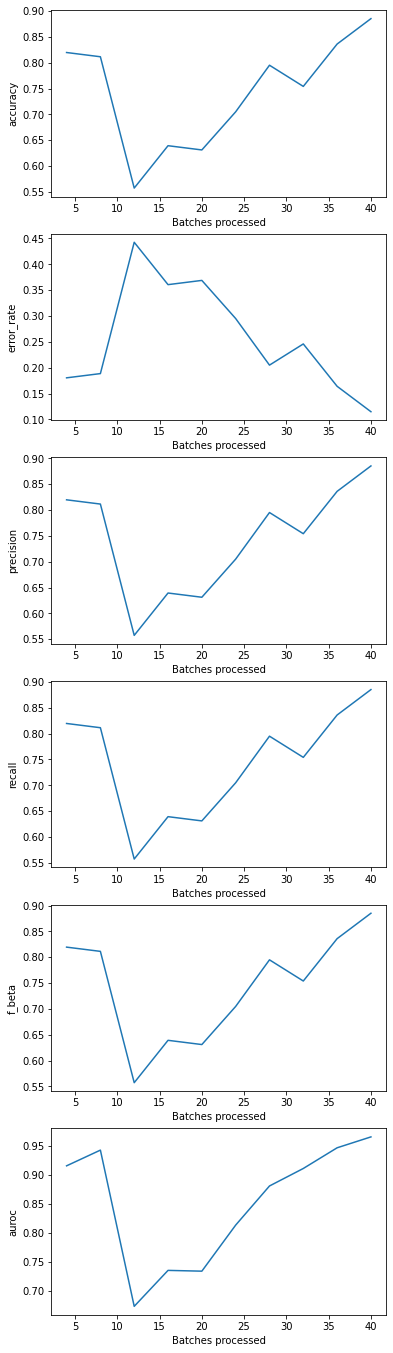

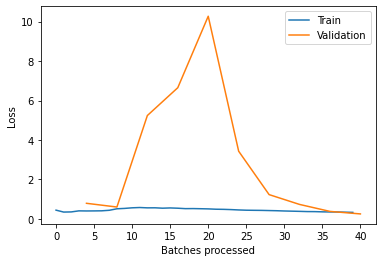

In [ ]:
#plotting the graph of metrics and losses 
learn1.recorder.plot_metrics()
learn1.recorder.plot_losses() 

In [ ]:
#saving the learner
learn1.save('DENSENET-121-STAGE-2')

In [ ]:
#classification interpretation contains the information about the model and the data
interp1 = ClassificationInterpretation.from_learner(learn1) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

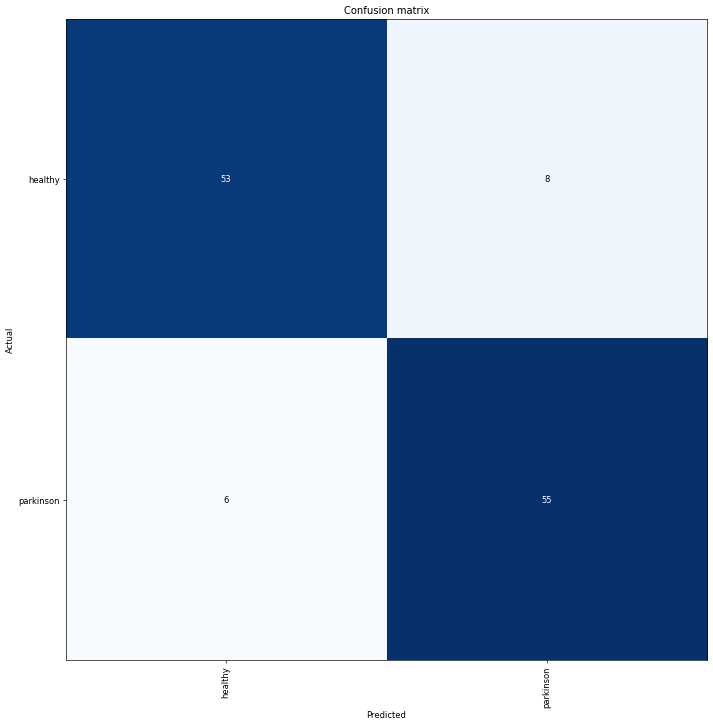

In [ ]:
#plotting the confusion matrix
interp1.plot_confusion_matrix(figsize = (12,12), dpi = 60) 

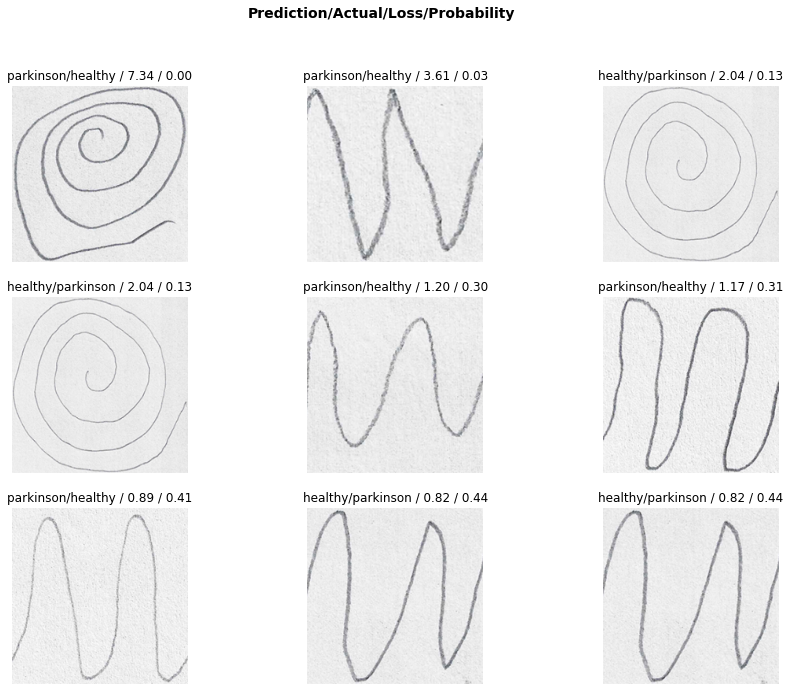

In [ ]:
#plotting the top losses 
interp1.plot_top_losses(9, figsize = (15,11))

In [ ]:
#most wrongly predicted images 
interp1.most_confused(min_val = 2)  

[('healthy', 'parkinson', 8), ('parkinson', 'healthy', 6)]

In [ ]:
learn1.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [128, 56, 56]        8,192      False     
___________________________________________________

TRANSFER LEARNING

ALEXNET MODEL

In [ ]:
#using alexnet architecture  
arch2 = models.alexnet 

In [ ]:
#creating a convolutional neural network using alexnet architecture
learn2 = cnn_learner(data, arch2, metrics=[accuracy, error_rate, 
                                         Precision(average='micro'),
                                         Recall(average='micro'),
                                         FBeta(average='micro'),
                                         AUROC()])  

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
#training the model
learn2.fit_one_cycle(10)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

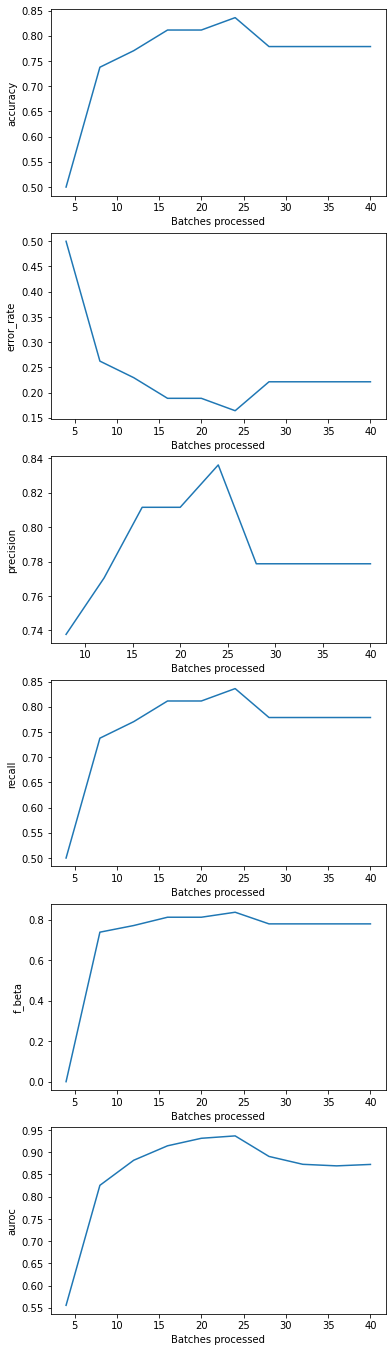

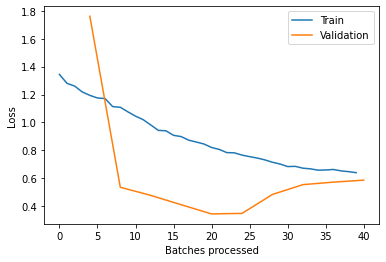

In [ ]:
#plotting the graph for metrics   
learn2.recorder.plot_metrics() 
learn2.recorder.plot_losses() 

In [ ]:
#saving the learner 
learn2.save('alexnet-STAGE-1')

In [ ]:
#finding the learning rate that has minimum loss
learn2.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-04


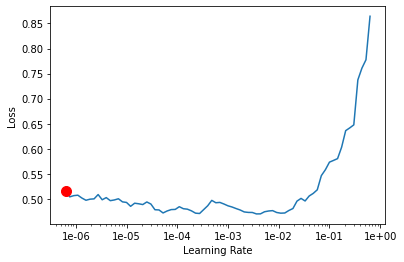

In [ ]:
#plotting the learning rate curve
learn2.recorder.plot(suggestion=True)

In [ ]:
#unfreezing the layers which don't contain BatchNorm 
learn2.unfreeze() 

In [ ]:
#training the classifier with different learning rates
learn2.fit_one_cycle(10,  max_lr=slice(1e-6,1e-4))  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

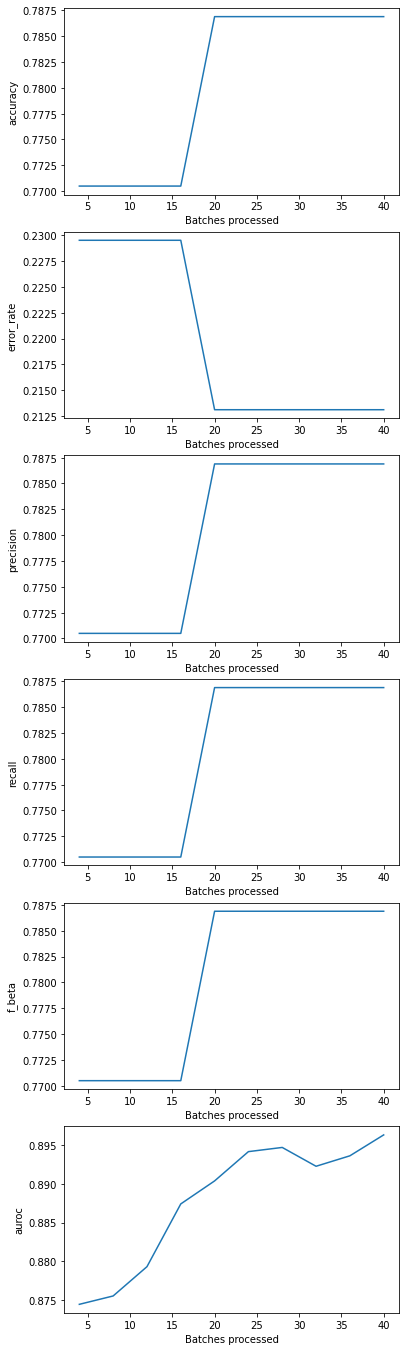

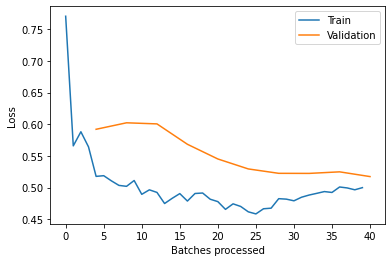

In [ ]:
#plotting the graph of metrics and losses 
learn2.recorder.plot_metrics()
learn2.recorder.plot_losses() 

In [ ]:
#saving the learner
learn2.save('alexnet-STAGE-2')

In [ ]:
#classification interpretation contains the information about the model and the data
interp2 = ClassificationInterpretation.from_learner(learn2) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

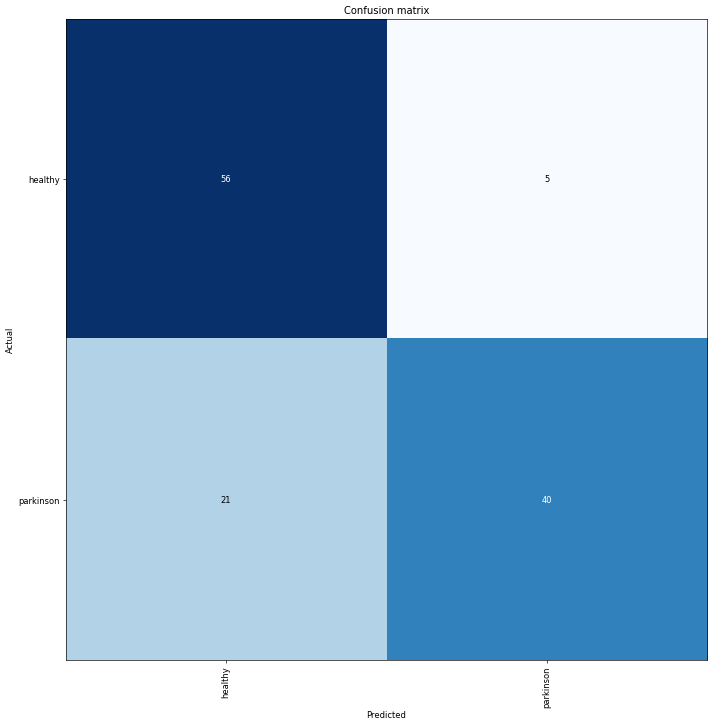

In [ ]:
#plotting the confusion matrix
interp2.plot_confusion_matrix(figsize = (12,12), dpi = 60) 

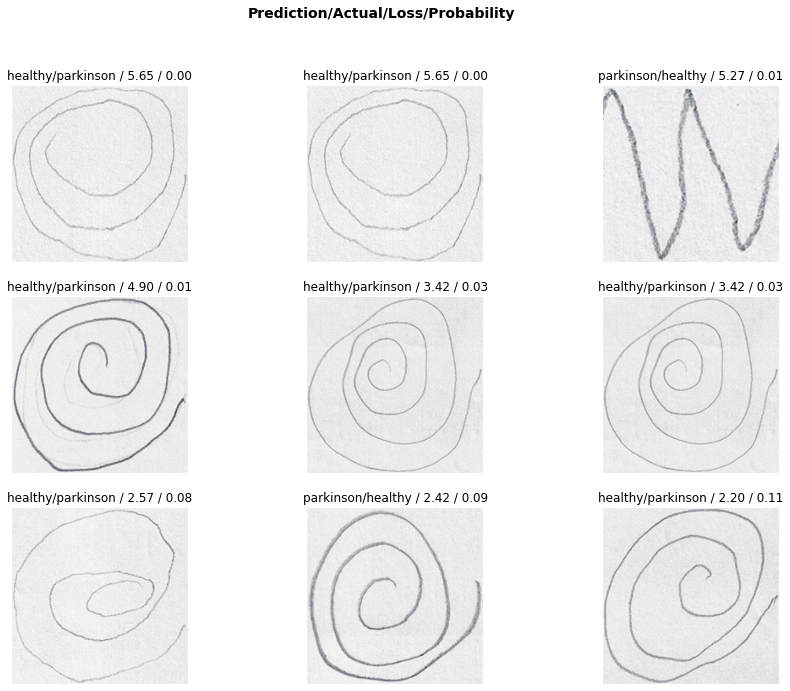

In [ ]:
#plotting the top losses
interp2.plot_top_losses(9, figsize = (15,11))

In [ ]:
#most wrongly predicted images 
interp2.most_confused(min_val = 2)  

[('parkinson', 'healthy', 21), ('healthy', 'parkinson', 5)]

In [ ]:
learn2.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 55, 55]         23,296     False     
______________________________________________________________________
ReLU                 [64, 55, 55]         0          False     
______________________________________________________________________
MaxPool2d            [64, 27, 27]         0          False     
______________________________________________________________________
Conv2d               [192, 27, 27]        307,392    False     
______________________________________________________________________
ReLU                 [192, 27, 27]        0          False     
______________________________________________________________________
MaxPool2d            [192, 13, 13]        0          False     
______________________________________________________________________
Conv2d               [384, 13, 13]        663,936    False     
___________________________________________________

TRANSFER LEARNING

VGG-19 

In [ ]:
#using vgg-19 architecture  
arch3 = models.vgg19_bn 

In [ ]:
#creating a convolutional neural network using VGG-19 architecture
learn3 = cnn_learner(data, arch3, metrics=[accuracy, error_rate, 
                                         Precision(average='micro'),
                                         Recall(average='micro'),
                                         FBeta(average='micro'),
                                         AUROC()])   

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
#training the model
learn3.fit_one_cycle(10) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

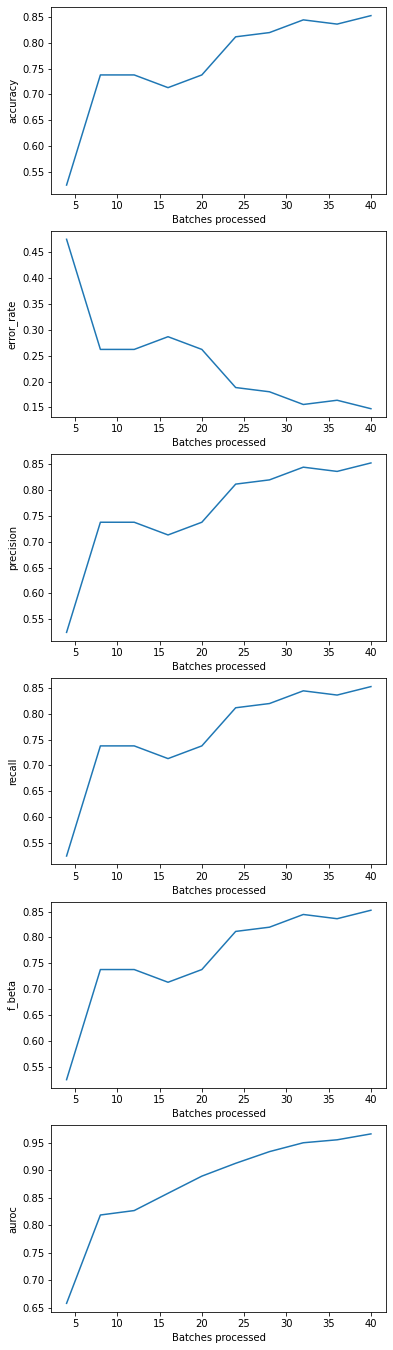

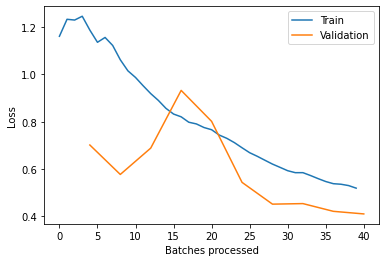

In [ ]:
#plotting the graph for metrics   
learn3.recorder.plot_metrics() 
learn3.recorder.plot_losses() 

In [ ]:
#saving the learner 
learn3.save('VGG-19-STAGE-1')

In [ ]:
#finding the learning rate that has minimum loss
learn3.lr_find()                

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.58E-03


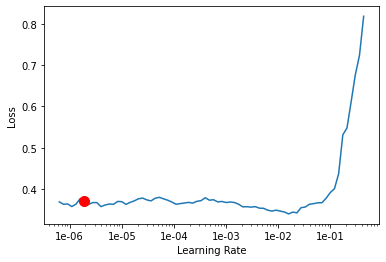

In [ ]:
#plotting the learning rate curve
learn3.recorder.plot(suggestion=True)

In [ ]:
#unfreezing the layers which don't contain BatchNorm 
learn3.unfreeze() 

In [ ]:
#training the classifier with different learning rates
learn3.fit_one_cycle(10,  max_lr=slice(1e-6,1e-4))  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

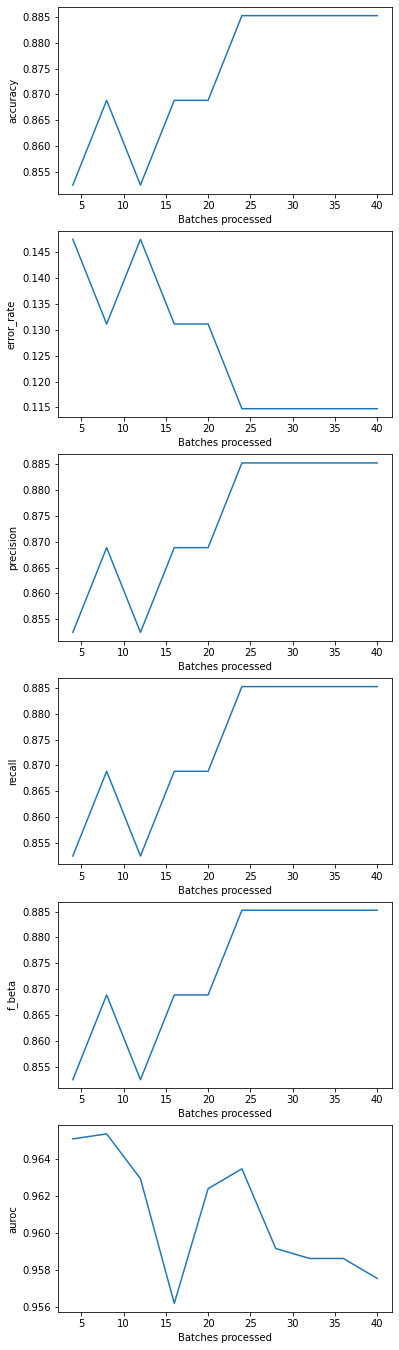

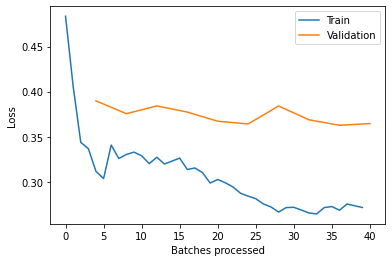

In [ ]:
#plotting the graph of metrics and losses 
learn3.recorder.plot_metrics()
learn3.recorder.plot_losses() 

In [ ]:
#saving the learner
learn3.save('VGG-19-STAGE-2')

In [ ]:
#classification interpretation contains the information about the model and the data
interp3 = ClassificationInterpretation.from_learner(learn3) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

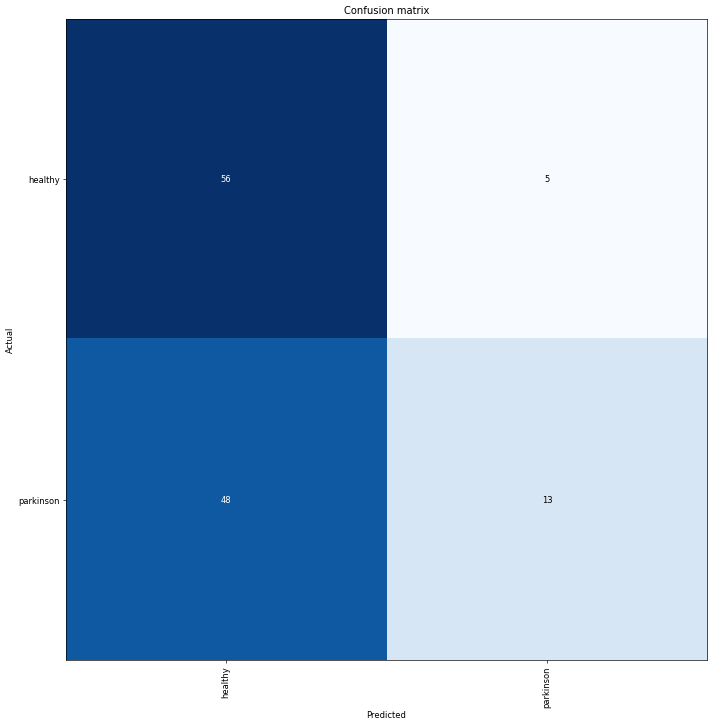

In [ ]:
#plotting the confusion matrix
interp3.plot_confusion_matrix(figsize = (12,12), dpi = 60) 

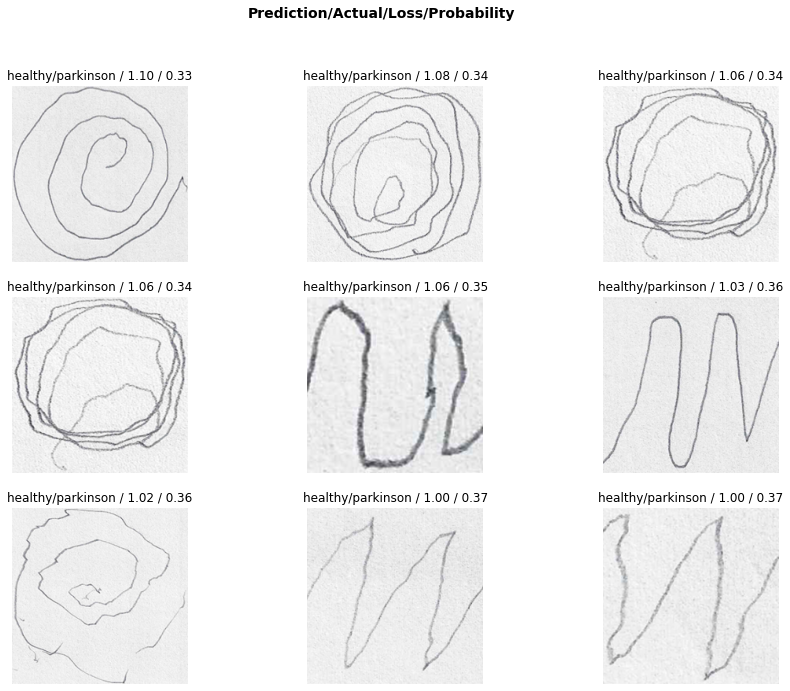

In [ ]:
#plotting the top losses
interp3.plot_top_losses(9, figsize = (15,11))

In [ ]:
#most wrongly predicted images 
interp3.most_confused(min_val = 2)  

[('parkinson', 'healthy', 48), ('healthy', 'parkinson', 5)]

In [ ]:
learn3.summary()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 224, 224]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [64, 224, 224]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 112, 112]       0          False     
___________________________________________________

TRANSFER LEARNING

SQUEEZENET

In [ ]:
#using sqeezenet architecture  
arch4 = models.squeezenet1_1

In [ ]:
#creating a convolutional neural network using sqeezenet architecture 
learn4 = cnn_learner(data, arch4, metrics=[accuracy, error_rate, 
                                         Precision(average='micro'),
                                         Recall(average='micro'),
                                         FBeta(average='micro'),
                                         AUROC()])   

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


In [ ]:
#training the model 
learn4.fit_one_cycle(10)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

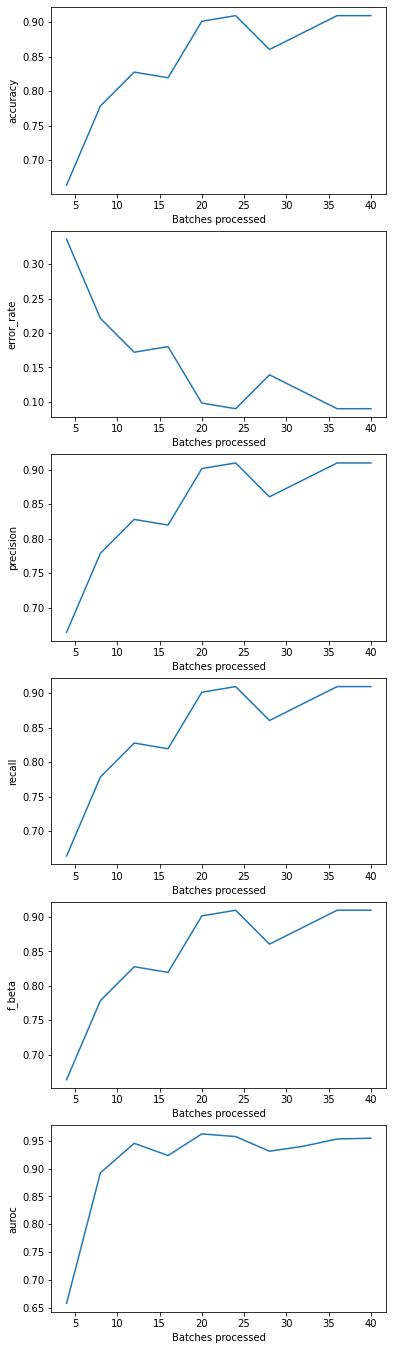

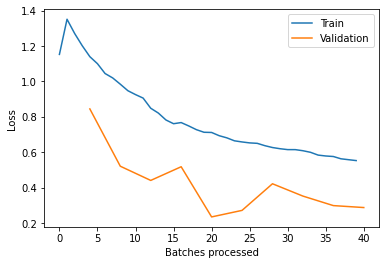

In [ ]:
#plotting the graph for metrics   
learn4.recorder.plot_metrics() 
learn4.recorder.plot_losses() 

In [ ]:
#saving the learner 
learn4.save('squeezenet-stage-1')

In [ ]:
#finding the learning rate that has minimum loss
learn4.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 7.59E-08


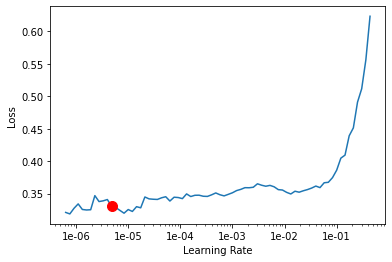

In [ ]:
#plotting the learning rate curve
learn4.recorder.plot(suggestion=True)

In [ ]:
#unfreezing the layers which don't contain BatchNorm 
learn4.unfreeze() 

In [ ]:
#training the classifier with different learning rates
learn4.fit_one_cycle(10,  max_lr=slice(1e-6,1e-4))  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

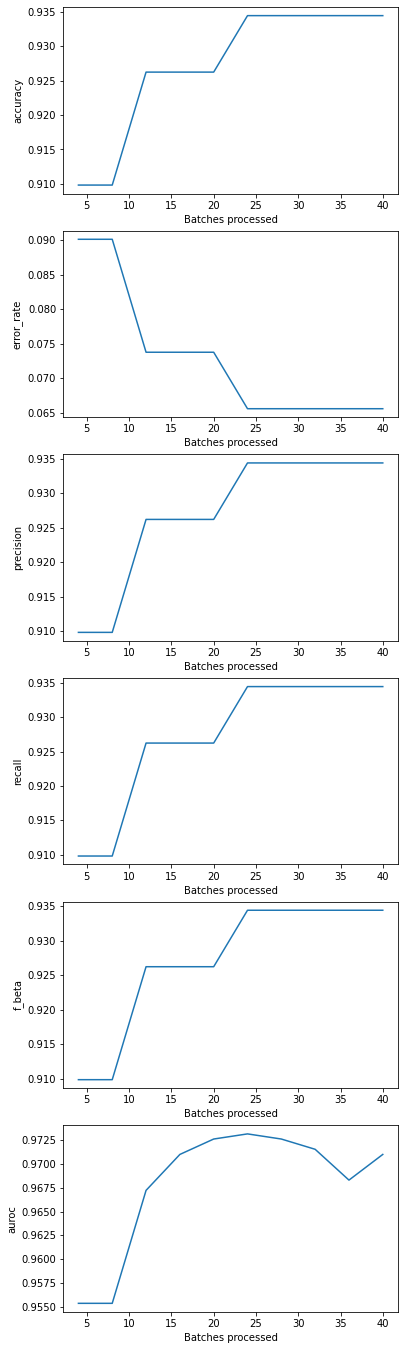

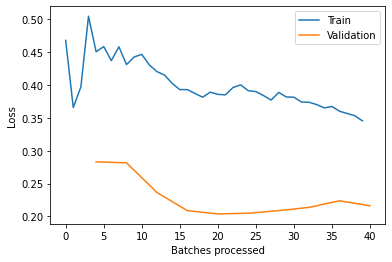

In [ ]:
#plotting the graph of metrics and losses 
learn4.recorder.plot_metrics()
learn4.recorder.plot_losses() 

In [ ]:
#saving the learner
learn4.save('squeezenet-stage-2')

In [ ]:
#classification interpretation contains the information about the model and the data
interp4 = ClassificationInterpretation.from_learner(learn4) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

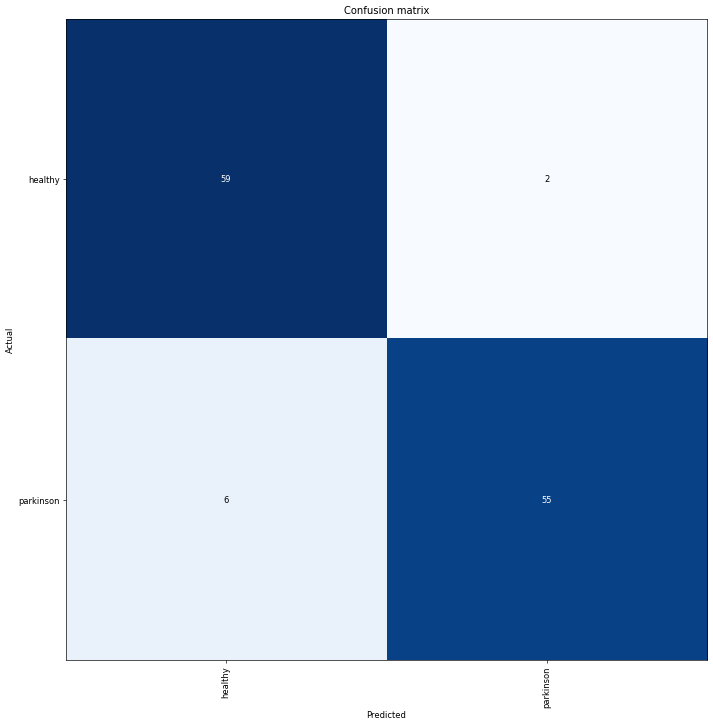

In [ ]:
#plotting the confusion matrix
interp4.plot_confusion_matrix(figsize = (12,12), dpi = 60) 

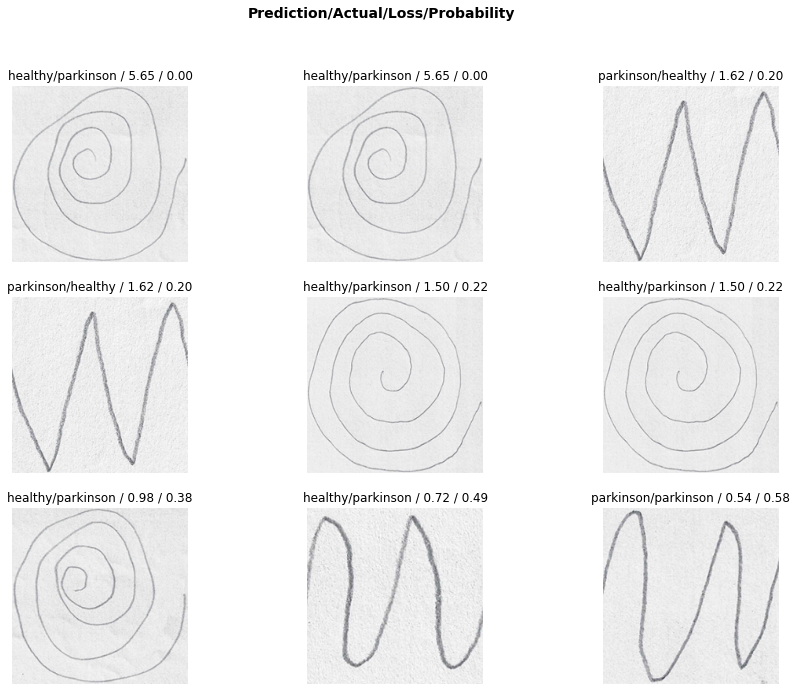

In [ ]:
#plotting the top losses
interp4.plot_top_losses(9, figsize = (15,11))

In [ ]:
#most wrongly predicted images 
interp4.most_confused(min_val = 2)  

[('parkinson', 'healthy', 6), ('healthy', 'parkinson', 2)]

In [ ]:
learn4.summary()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 111, 111]       1,792      False     
______________________________________________________________________
ReLU                 [64, 111, 111]       0          False     
______________________________________________________________________
MaxPool2d            [64, 55, 55]         0          False     
______________________________________________________________________
Conv2d               [16, 55, 55]         1,040      False     
______________________________________________________________________
ReLU                 [16, 55, 55]         0          False     
______________________________________________________________________
Conv2d               [64, 55, 55]         1,088      False     
______________________________________________________________________
ReLU                 [64, 55, 55]         0          False     
___________________________________________________

PRODUCTION

In [ ]:
#creating a file named 'export.pkl' that contains everything for deployment 
learn.export()

In [ ]:
learn.load('RESNET-50-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/MyDrive/hwd;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/MyDrive/hwd;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_

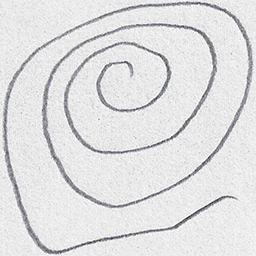

In [ ]:
#opening the image 
img = open_image(path/'spiral/testing/healthy/V11HE01.png')
img 

In [ ]:
#the learner is created in a production environment to make sure that that path contains the file 'export.pkl' 
learn = load_learner(path) 

In [ ]:
#predicting the class of the selected image
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj 

'healthy'